In [ ]:
!nvidia-smi --query-gpu=name --format=csv,noheader

Tesla T4


# Install

In [ ]:
!git clone https://github.com/NVIDIA/apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Cloning into 'apex'...
remote: Enumerating objects: 9901, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 9901 (delta 4), reused 6 (delta 0), pack-reused 9881
Receiving objects: 100% (9901/9901), 14.85 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (6809/6809), done.
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-pa

In [ ]:
!git clone https://github.com/tenebo/mellotron-korean.git mellotron
%cd mellotron
!git submodule init; git submodule update

Cloning into 'mellotron'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 200 (delta 88), reused 188 (delta 80), pack-reused 0
Receiving objects: 100% (200/200), 4.19 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/mellotron
Submodule 'waveglow' (https://github.com/NVIDIA/waveglow.git) registered for path 'waveglow'
Cloning into '/content/mellotron/waveglow'...
Submodule path 'waveglow': checked out '2fd4e63e2918012f55eac2c8a8e75622a39741be'


In [ ]:
!cat requirements.txt | xargs -n 1 pip install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 35.7 MB 483 kB/s 
  Created wheel for matplotlib: filename=matplotlib-2.1.0-cp37-cp37m-linux_x86_64.whl size=10229358 sha256=9c346a6a30c16a8a74b02e3164d687276885487b6a3c350209c1b634e4c7c3e0
  Stored in directory: /root/.cache/pip/wheels/73/91/90/82e0effbb1a7e87eede54caf035471f9dc061eac46c14a5152
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
seaborn 0.11.2 requires matplotlib>=2.2, but you have matplotlib 2.1.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.1.0 which is incompatible.
m

In [ ]:
!pip install numba==0.48

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 4.8 MB/s 
     |████████████████████████████████| 20.2 MB 6.1 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires librosa>=0.7.2, but you have librosa 0.6.0 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

from hparams import create_hparams
from model import Tacotron2, load_model
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

In [ ]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

In [ ]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

In [ ]:
def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams.sampling_rate)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [ ]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

# Model Setup

## Load Models

In [ ]:
!mkdir models
!gdown "https://drive.google.com/u/0/uc?id=1-QprmwOAtb_L2F2iLkaDRAYfenb_jTba" -O ./models/mellotron_libritts.pt
!gdown "https://drive.google.com/u/0/uc?id=1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF" -O ./models/waveglow_256channels_v5.pt

Downloading...
From: https://drive.google.com/u/0/uc?id=1-dsk2CyrwqswmAKrscPdPmvhjUSu9tmf
To: /content/mellotron/models/mellotron_libritts.pt
100% 383M/383M [00:02<00:00, 188MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1okuUstGoBe_qZ4qUEF8CcwEugHP7GM_b
To: /content/mellotron/models/waveglow_256channels_v4.pt
100% 676M/676M [00:04<00:00, 162MB/s]


## Setup dataloaders

In [ ]:
checkpoint_path = "models/mellotron_libritts.pt"
mellotron = load_model(hparams).cuda().eval()
mellotron.load_state_dict(torch.load(checkpoint_path)['state_dict'])
waveglow_path = 'models/waveglow_256channels_v5.pt'
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
denoiser = Denoiser(waveglow).cuda().eval()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

## Load data

In [ ]:
arpabet_dict = cmudict.CMUDict('data/cmu_dictionary')
audio_paths = 'data/examples_filelist.txt'
dataloader = TextMelLoader(audio_paths, hparams)
datacollate = TextMelCollate(1)

## Define Speakers Set

In [ ]:
file_idx = 0
audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]

# get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text))[None, :].cuda()    
pitch_contour = dataloader[file_idx][3][None].cuda()
mel = load_mel(audio_path)
print(audio_path, text)

# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = mellotron.parse_batch(datacollate([dataloader[file_idx]]))

data/example1.wav 반짝반짝 작은별 아름답게 비치네.


In [ ]:
ipd.Audio(audio_path, rate=hparams.sampling_rate)

## TTS inference

In [ ]:
text1 = "이런 일이."

seed = 2000
torch.manual_seed(seed)
np.random.seed(seed)

text_encoded = torch.LongTensor(text_to_sequence(text1))[None, :].cuda()
pitch_contour[:] = 0

speaker_id = torch.LongTensor([0]).cuda()

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = mellotron.inference(
        (text_encoded, mel, speaker_id, pitch_contour))
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.1)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:720: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mag = np.abs(S).astype(np.float)


# Style Transfer (Rhythm and Pitch Contour)

In [ ]:
with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm = mellotron.forward(x)
    rhythm = rhythm.permute(1, 0, 2)

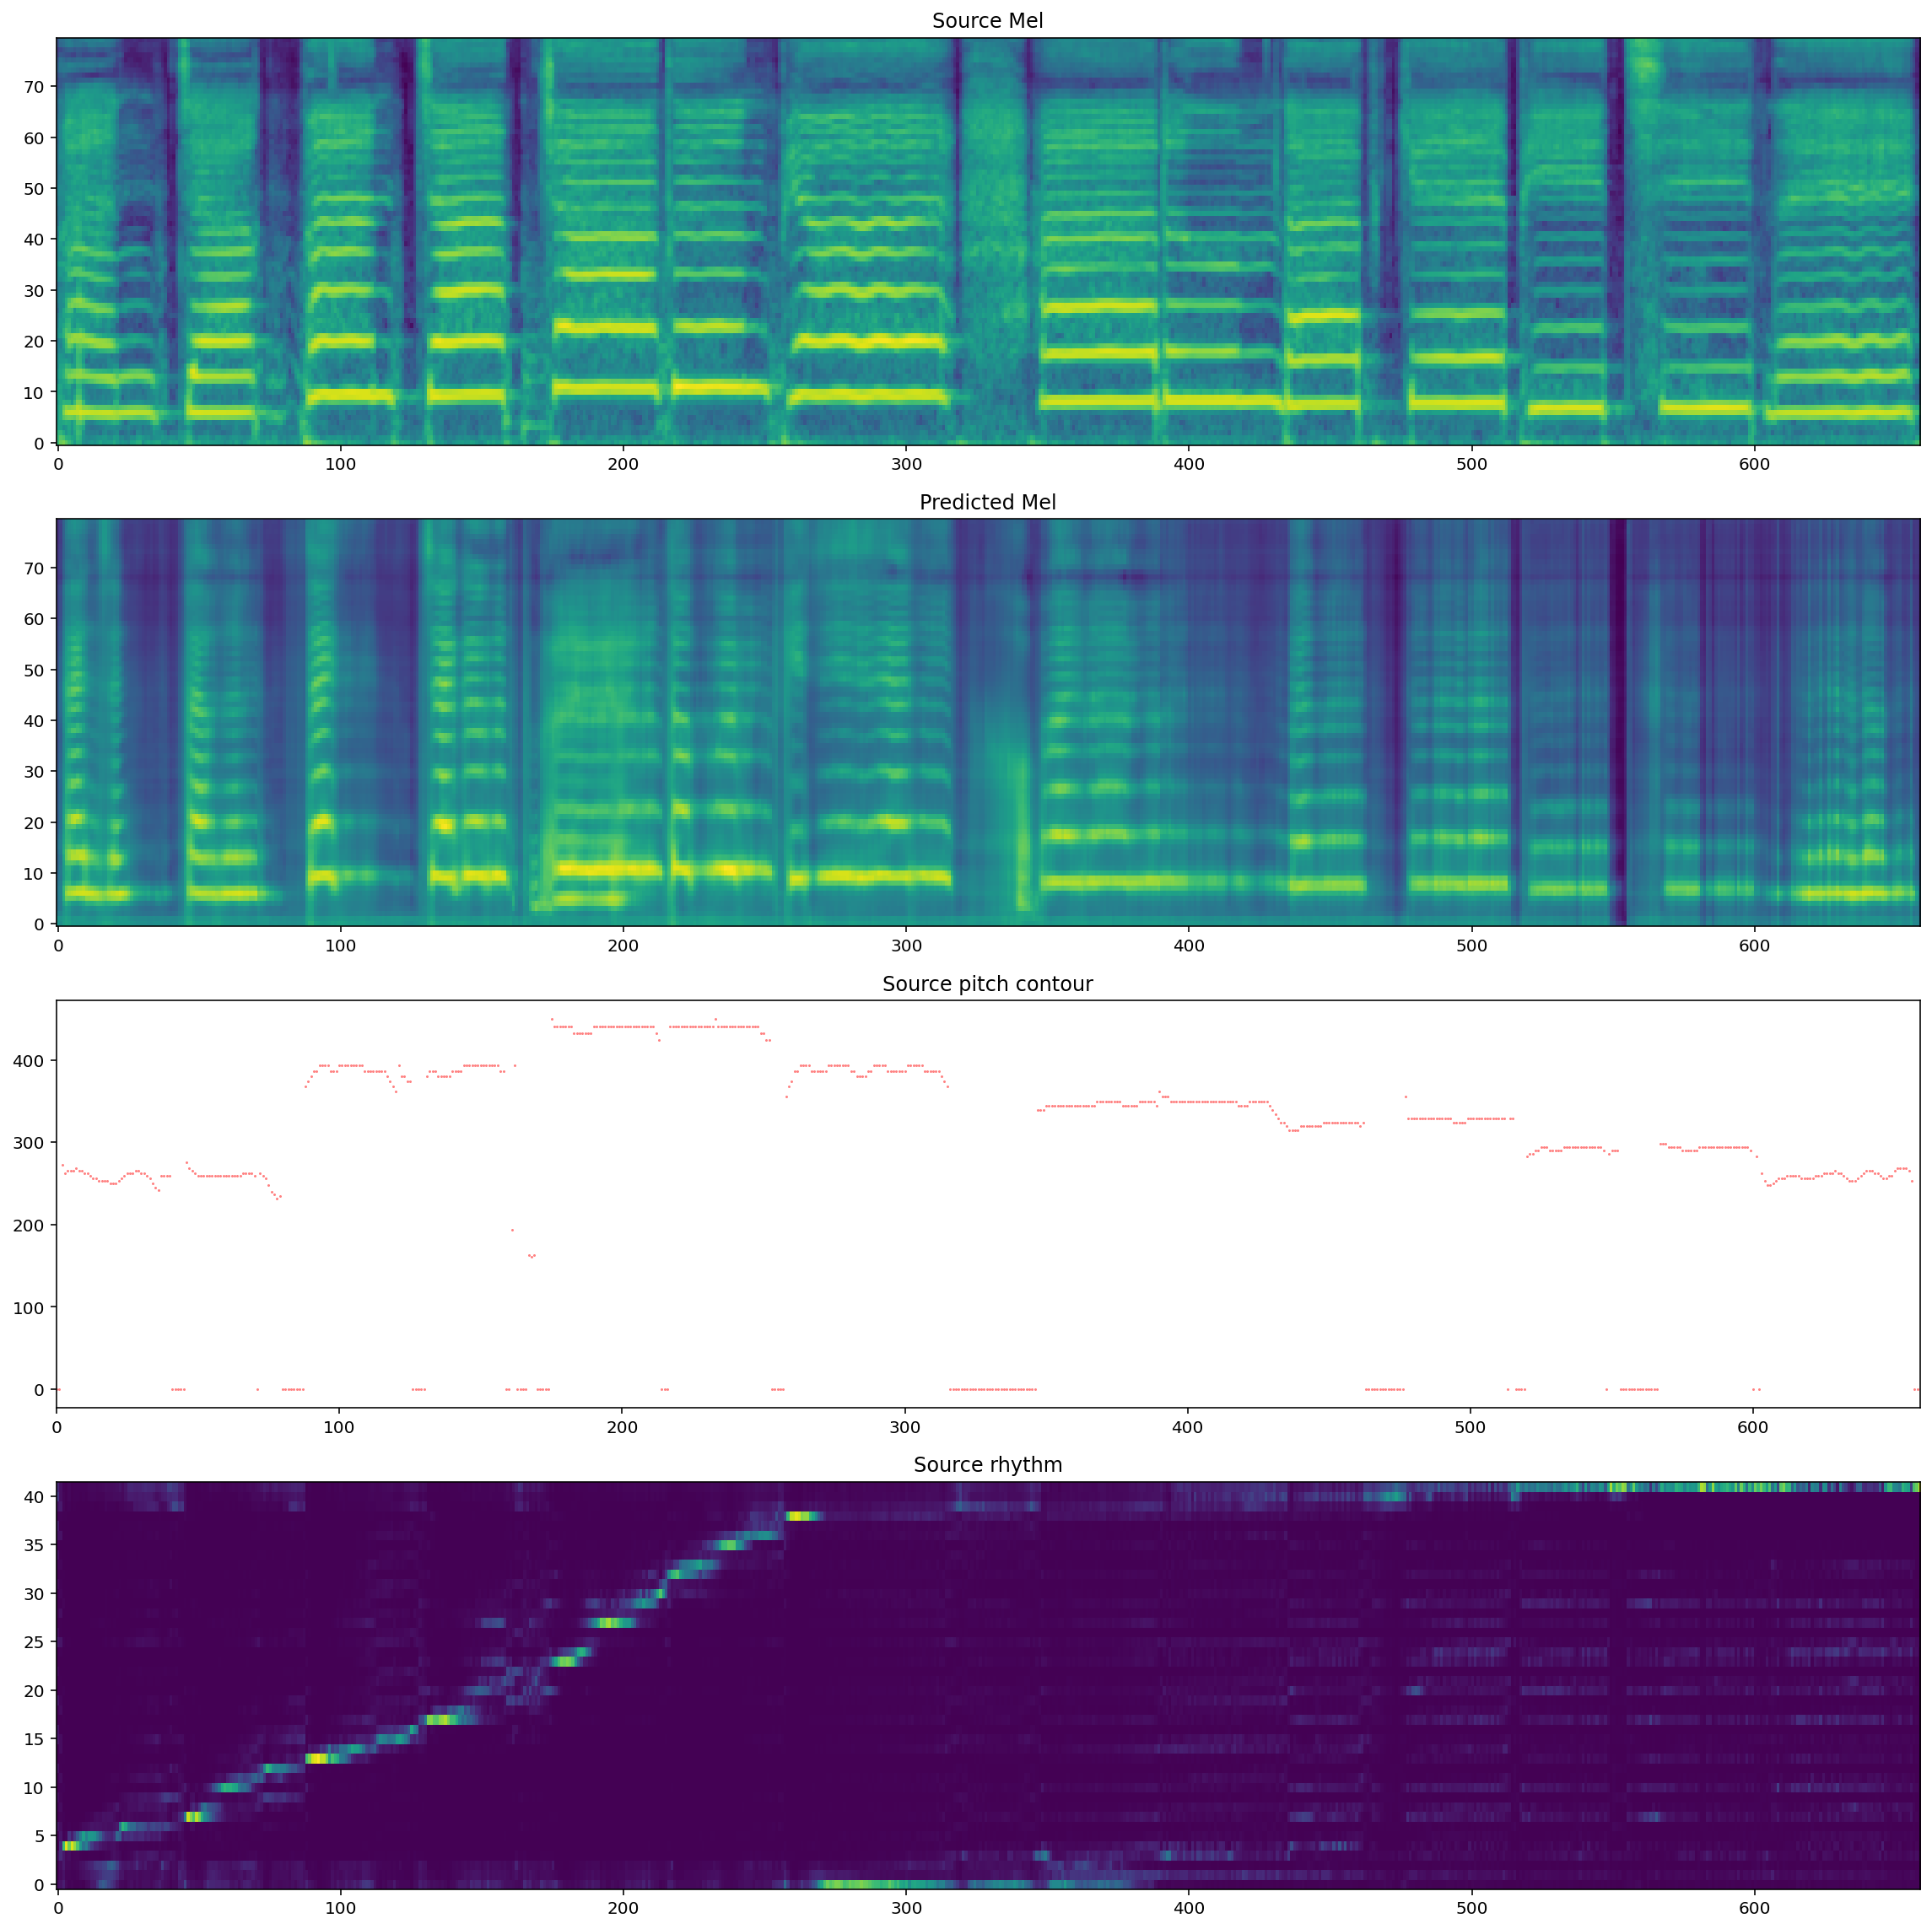

In [ ]:
speaker_id = 0
speaker_id = torch.LongTensor([speaker_id]).cuda()

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = mellotron.inference_noattention(
        (text_encoded, mel, speaker_id, pitch_contour, rhythm))

plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)

In [ ]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:720: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mag = np.abs(S).astype(np.float)


# Singing Voice from Music Score

In [ ]:
data = get_data_from_musicxml('data/haendel_hallelujah.musicxml', 132, convert_stress=True)
panning = {'Soprano': [-60, -30], 'Alto': [-40, -10], 'Tenor': [30, 60], 'Bass': [10, 40]}

In [ ]:
n_speakers_per_part = 4
frequency_scaling = 0.4
n_seconds = 90
audio_stereo = np.zeros((hparams.sampling_rate*n_seconds, 2), dtype=np.float32)
for i, (part, v) in enumerate(data.items()):
    rhythm = data[part]['rhythm'].cuda()
    pitch_contour = data[part]['pitch_contour'].cuda()
    text_encoded = data[part]['text_encoded'].cuda()
    
    for k in range(n_speakers_per_part):
        pan = np.random.randint(panning[part][0], panning[part][1])
        if any(x in part.lower() for x in ('soprano', 'alto', 'female')):
            speaker_id = torch.LongTensor([next(female_speakers)]).cuda()
        else:
            speaker_id = torch.LongTensor([next(male_speakers)]).cuda()
        print("{} MellotronID {} pan {}".format(part, speaker_id.item(), pan))

        with torch.no_grad():
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments_transfer = mellotron.inference_noattention(
                (text_encoded, mel, speaker_id, pitch_contour*frequency_scaling, rhythm))

            audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[0, 0]
            audio = audio.cpu().numpy()
            audio = panner(audio, pan)
            audio_stereo[:audio.shape[0]] += audio            
            write("{} {}.wav".format(part, speaker_id.item()), hparams.sampling_rate, audio)

In [ ]:
audio_stereo = audio_stereo / np.max(np.abs(audio_stereo))
write("audio_stereo.wav", hparams.sampling_rate, audio_stereo)
ipd.Audio([audio_stereo[:,0], audio_stereo[:,1]], rate=hparams.sampling_rate)